## VGG model from scratch

In [37]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
import json
from utils import *
import numpy as np
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model # Layers to be used in the model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

### Fetching mapping for VGG ids to imagenet ids

In [4]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [9]:
classes[:10]

[u'tench',
 u'goldfish',
 u'great_white_shark',
 u'tiger_shark',
 u'hammerhead',
 u'electric_ray',
 u'stingray',
 u'cock',
 u'hen',
 u'ostrich']

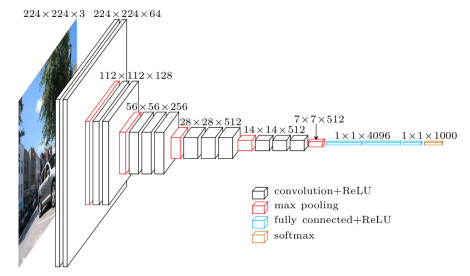

In [11]:
from IPython.display import Image
Image("img/vgg.png")

## Model Creation

VGG has one type of convolutional block, and one type of dense(fully connected layer) block.(A fully connected layer has each neuron connected to every other neuron, like a traditional MLP). 

In [12]:
def ConvBlock(layers, model, filters):
    """
    @param layers: Number of layers to be added the the base model
    @param model: Base model
    @param filters: Dimentionality of the output layer once convolution is performed
    """
    for i in range(layers):
        model.add(ZeroPadding2D((1,1))) # Apply symmetric padding to height and width of the image
        model.add(Convolution2D(filters, 3, 3, activation='relu')) # ReLU is used because it genrally performs better in images
    model.add(MaxPooling2D((2, 2), strides=(2,2))) # Apply max-pooling layer with stride 2 after the convolution layers
        

Fully connected block definition

In [13]:
def FCBlock(model):
    """
    @param model: Base model
    """
    model.add(Dense(4096, activation='relu')) # Implements the function output = activation(dot(input, kernel) + bias). 
    model.add(Dropout(0.5)) # Dropout layer randomly drops the weights from few neurons in the network. Helps imporve accuracy


Now we will subtract the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Also, the VGG model was written and it expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:

In [18]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    """
    @param x: Vector containing the RGB values
    """
    x = x - vgg_mean # Subtract mean so that average of the vector is 0
    return x[:, ::-1] # Reverse axis to use BGR instead of RGB

Now we will implement the VGG architecture

In [27]:
def VGG_16():
    model = Sequential() # Linear stack of layers
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))
    
    # Adding the convolution layers
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten()) # Flattens the input so that softmax layer may be applied
    
    # Adding final fully connected layers
    FCBlock(model)
    FCBlock(model)
    # Adding softmax layer which will give the probablity for each of the 1000 classes
    model.add(Dense(1000, activation='relu'))
    return model

Initializing the model.

In [28]:
model = VGG_16()

We need the weights used for the model by the researches because training the model will need the entire ImageNet dataset.

In [29]:
FILES_PATH = 'http://files.fast.ai/models/'

In [30]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

### Generate predictions

In [34]:
batch_size = 4
path = "data/dogscats/"

In [35]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [40]:
%matplotlib inline

Found 202 images belonging to 2 classes.
Found 103 images belonging to 2 classes.


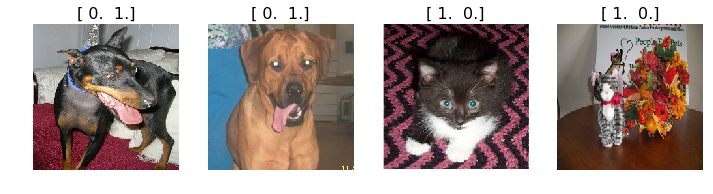

In [47]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size)

imgs, labels = next(batches)

plots(imgs, titles=labels)

Model will give out 1000 probablities for each input image. We can find the maximum of these probabilities to find the prediction of the model.

In [45]:
def pred_batch(imgs):
    predictions = model.predict(imgs)
    idxs = np.argmax(predictions, axis=1) # Find the maximum value of from the array of predictions
    print('Shape: {}'.format(predictions.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(predictions[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(predictions[i, idx], classes[idx])) # Prints out all predictions in descending order

In [48]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [ 3.1169  0.      4.5894  2.5672  4.975 ]

Predictions prob/class: 
  20.6115/miniature_pinscher
  11.0031/Rhodesian_ridgeback
  11.3382/Persian_cat
  7.4765/vase
